In [255]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
import warnings
import matplotlib.pyplot as plt

In [257]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm

In [258]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.0.1 
xwmt version 0.1.0 
xwmb version 0.0.1


### Plotting routines

In [259]:
import matplotlib.pyplot as plt

def hovmoller(wmt, var, robust=False, units="kg", **kwargs):
    da = wmt[var]
    if robust:
        vmax = np.abs(da).quantile(0.95).compute()
        kwargs["vmin"] = -vmax
        kwargs["vmax"] = vmax

    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    time_idx_bounds = xr.DataArray(np.arange(0, wmt.time_bounds.size), dims=('time_bounds',))
    pc = plt.pcolor(
        time_idx_bounds,
        coord_bounds,
        da.transpose() if da.dims[0] == "time" else da,
        **kwargs
    )

    dtick = da.time.size//12
    date_str = [f"{d.year}-{str(d.month).zfill(2)}-{str(d.day).zfill(2)}" for d in wmt["time_bounds"].values[::dtick]]
    plt.xticks(time_idx_bounds[::dtick], date_str, rotation=90)
    plt.colorbar(label=f"transformation rate [{units}]")
    for coord_bound in coord_bounds:
        plt.axhline(coord_bound, color="k", lw=0.25)
    
    return pc

def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

### Load grids and data

In [260]:
diag_frequency = "monthly" # switch to "monthly" for testing

from loading import *
grid = load_baltic("zstr", diag_frequency, online_density=True)

### Specify target grid coordinates

In [261]:
# We specify our target density bins based on the online density-coordinate diagnostics
grid_ref = load_baltic("rho2", "monthly")
grid._ds = grid._ds.assign_coords({
    "sigma2_l_target": grid_ref._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
    "sigma2_i_target": grid_ref._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
})
grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)
grid

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary='extend'):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary='extend'):
  * center   z_l --> outer
  * outer    z_i --> center
Z_target Axis (not periodic, boundary='extend'):
  * center   sigma2_l_target --> outer
  * outer    sigma2_i_target --> center

# Part 1. Water mass budgets within a fixed sub-region

### Collecting high-level budget terms

In [262]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid, budgets_dict)

/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


### Specifying the horizontal boundaries of our water mass

/vftmp/Henri.Drake/pid5324/ipykernel_19143/92035112.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pc, label="depth [m]")


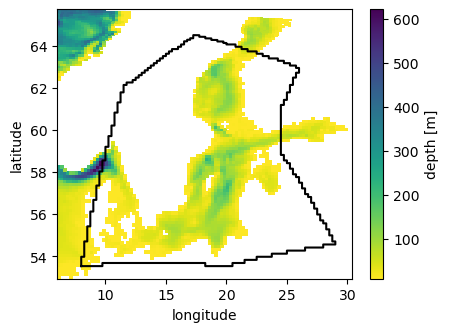

In [263]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "intBaltic"
lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");

### Computing water mass budgets

In [309]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        region
    )
    wmb.mass_budget(lam, along_section=False)
    wmb.wmt.load()
    wmt = wmb.wmt

ValueError: Dimensions ('sect',) not found in data dimensions ('xh', 'yh', 'time', 'nv', 'z_l', 'z_i', 'xq', 'yq', 'time_bounds', 'sigma2_l_target', 'sigma2_i_target')

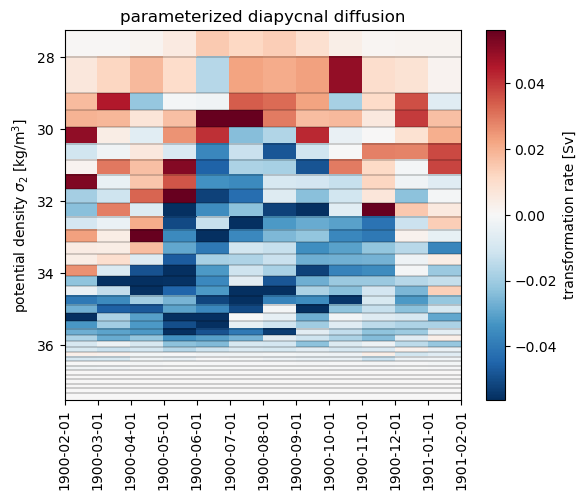

In [265]:
toSv = 1.e-6/wmb.rho_ref
pc = hovmoller(wmt*toSv, "diffusion", cmap="RdBu_r", units="Sv", robust=True)
plt.ylim(37.5, 27.25);
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.title("parameterized diapycnal diffusion");

/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


(150.0, 0.0)

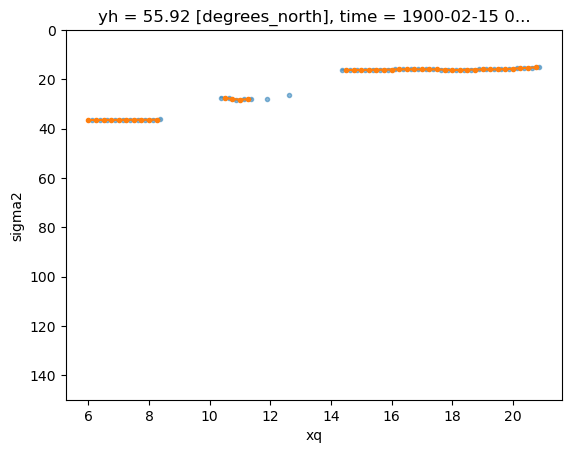

In [282]:
grid._ds['sigma2'].isel(yh=20, time=0, z_l=0).plot(alpha=0.5, marker=".")
plt.ylim(150, 0)

σu.isel(yh=20, z_l=0).plot(marker=".")
plt.ylim(150, 0)

/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning

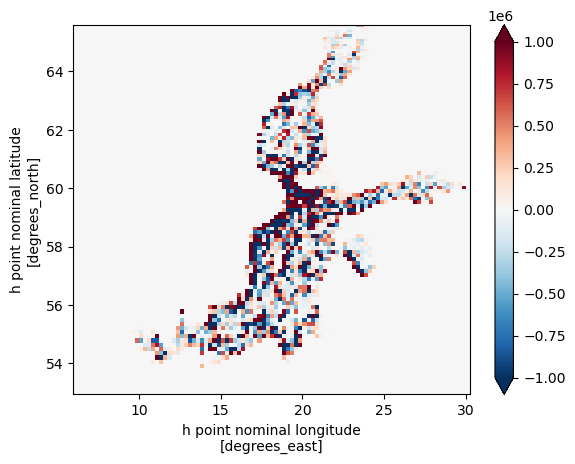

In [304]:
σu = grid.interp(grid._ds['sigma2'], "X").isel(time=0)
σv = grid.interp(grid._ds['sigma2'], "Y").isel(time=0)

div_u = grid.diff(grid.transform(
    grid._ds['umo'].isel(time=0).fillna(0.),
    "Z",
    xr.DataArray([0, 25], dims=("tempy")),
    target_data=σu,
    method="conservative"
).isel(tempy=0).fillna(0.), "X")
div_v = grid.diff(grid.transform(
    grid._ds['vmo'].isel(time=0).fillna(0.),
    "Z",
    xr.DataArray([0, 25], dims=("tempy")),
    target_data=σv,
    method="conservative"
).isel(tempy=0).fillna(0.), "Y")

(div_u + div_v).plot(vmin=-1e6, vmax=1e6, cmap="RdBu_r")

/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


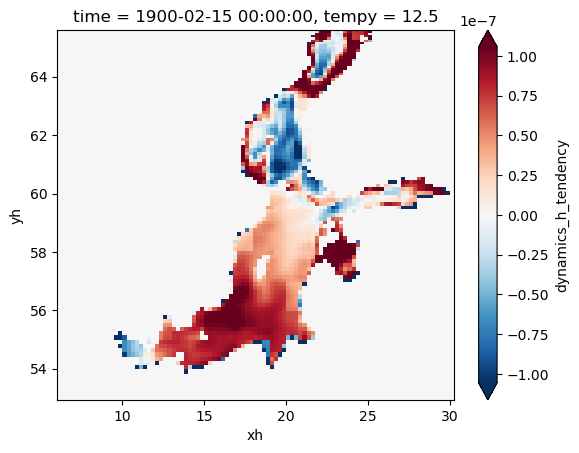

In [297]:
grid.transform(
    grid._ds['dynamics_h_tendency'],
    "Z",
    xr.DataArray([0, 25], dims=("tempy")),
    target_data=grid._ds['sigma2'],
    method="conservative"
).isel(time=0).plot(robust=True)

In [222]:
grid.interp(grid._ds['sigma2'], "Y").isel(time=0)

/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<xarray.DataArray 'sigma2' (zl: 75, yq: 106, xh: 97)>
dask.array<getitem, shape=(75, 106, 97), dtype=float32, chunksize=(75, 106, 97), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 6.125 6.375 6.625 6.875 ... 29.38 29.62 29.88 30.12
    time     object 1900-02-15 00:00:00
  * zl       (zl) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
  * yq       (yq) float64 52.94 53.09 53.24 53.39 ... 65.35 65.44 65.52 65.6

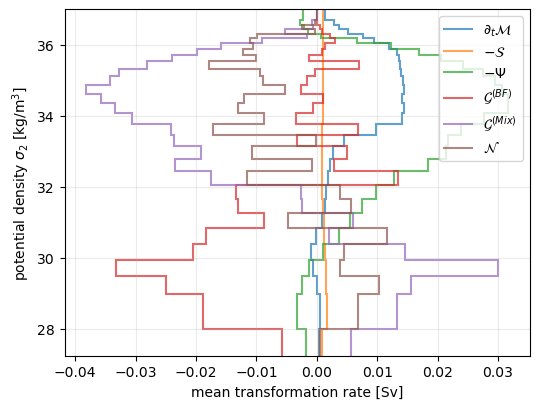

In [216]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_mean = wmt.mean('time')*toSv
stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
stairs(-wmt_mean, 'overturning',               label=r"$-\Psi$",                   **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{N}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(27.25, 37.0);

In [202]:
import matplotlib
import xhistogram

tmp = xhistogram.xarray.histogram(
    grid._ds['thetao_bounds'], grid._ds['so_bounds'],
    bins=[np.arange(-4, 30, 0.1), np.arange(-2, 40, 0.1)],
    weights=grid._ds['thkcello_bounds'],
    block_size=None,
    density=True
).compute()

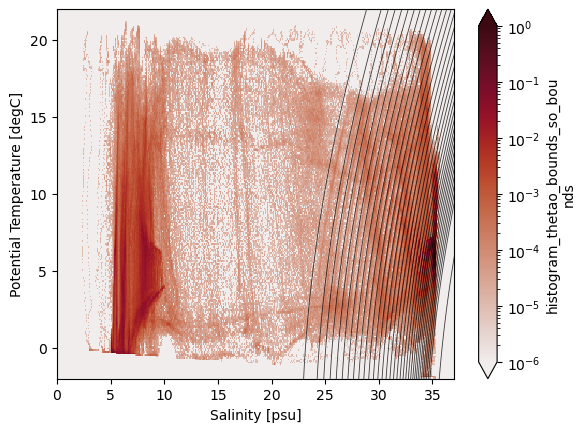

In [342]:
vmax = tmp.max().values
import cmocean
tmp.where(tmp!=0, 1e-16).plot(norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=1), extend="both", cmap=cmocean.cm.amp)
import gsw
gsw.sigma2(tmp.so_bounds_bin, tmp.thetao_bounds_bin).plot.contour(levels=grid._ds['sigma2_i'], x="so_bounds_bin", colors="k", linewidths=0.6, alpha=0.75)
plt.xlim(0, 37)
plt.ylim(-2, 22);

# Part 2. Global water mass budgets

### Minimal diagnostics for closing the mass budget and estimating physical and numerical mixing globally


In [220]:
region = xr.ones_like(grid._ds['deptho'])

When the region is taken to be the whole domain, the horizontal cross-boundary fluxes vanish either because there is no flow through land or because of lateral boundary conditions of no-normal flow or periodicity (e.g. at the zonal boundaries and tripolar grid fold). Rather than having to put in all of the effort to compute this vanishing term explicitly (and saving the required mass transport diagnostics), we can simply use the `assert_zero_transport` flag when instantiating the `WaterMassBudget` class.

**Note:** This probably needs to be revisiting for a regional domain, where there may be imposed normal flow at the boundaries... If that is the case, then the overturning would need to be included in the calculation.

Also, instead of working from the full MOM6 budget provided by `xbudget`, we here include the bare minimum budget information necessary to close the global water mass budget (and thereby diagnose numerical mixing). For closing the heat budget, for example, we only need 6 three-dimensional tendency diagnostics plus the snapshots of thickness to get the mass tendency.

In [221]:
grid = load_baltic("rho2", diag_frequency)
budgets_dict_minimal = xbudget.load_yaml("MOM6_num_mixing.yaml")
xbudget.collect_budgets(grid._ds, budgets_dict_minimal)

wmb_min = xwmb.WaterMassBudget(
    grid,
    budgets_dict_minimal,
    region,
    assert_zero_transport=True
)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb_min.mass_budget(lam)
    wmb_min.wmt.load()
    wmt_min = wmb_min.wmt

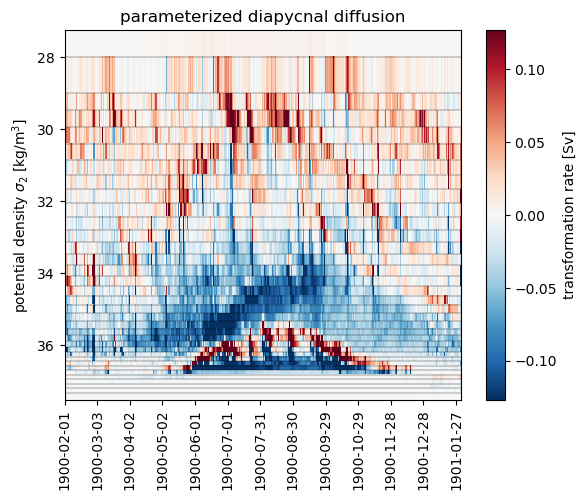

In [222]:
toSv = 1.e-6/wmb_min.rho_ref
pc = hovmoller(wmt_min*toSv, "diffusion", cmap="RdBu_r", units="Sv", robust=True)
plt.ylim(37.5, 27.25);
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.title("parameterized diapycnal diffusion");

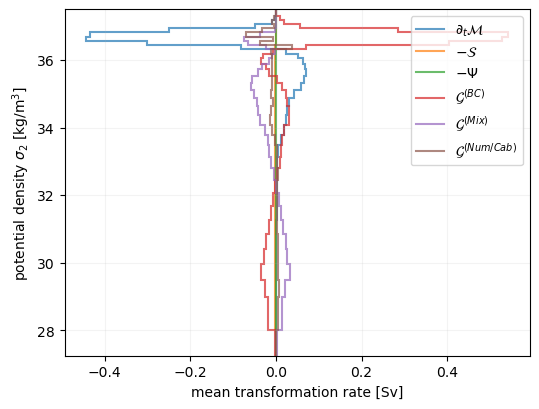

In [223]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_min_mean = wmt_min.mean('time')*toSv
stairs( wmt_min_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
stairs(-wmt_min_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
stairs(-wmt_min_mean, 'overturning',               label=r"$-\Psi$",                   **kwargs)
stairs( wmt_min_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_min_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_min_mean, 'spurious_numerical_mixing', label=r"$\mathcal{N}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.15)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(27.25, 37.5);